### Problem Statement:
Predict whether a loan application should be approved or not, based on the applicant’s personal, financial, and property details.

#### Project Goal / Solution
1. Goal: Build a machine learning model that accurately predicts Loan_Status using applicant and loan data.

2. Business Value: Improve loan approval process efficiency and reduce default risk.


| Column Name            | Description                                         |
| ---------------------- | --------------------------------------------------- |
| **Loan\_ID**           | Unique identifier for each loan application         |
| **Gender**             | Gender of the applicant: Male or Female             |
| **Married**            | Marital status: Yes or No                           |
| **Dependents**         | Number of dependents: 0, 1, 2, 3+                   |
| **Education**          | Educational qualification: Graduate or Not Graduate |
| **Self\_Employed**     | Employment status: Self-employed or Not             |
| **ApplicantIncome**    | Monthly income of the main applicant                |
| **CoapplicantIncome**  | Monthly income of the co-applicant                  |
| **LoanAmount**         | Requested loan amount (in thousands)                |
| **Loan\_Amount\_Term** | Term of the loan in months (e.g., 360 for 30 years) |
| **Credit\_History**    | Record of credit history (1 = good, 0 = bad)        |
| **Property\_Area**     | Type of property area: Urban, Semiurban, or Rural   |
| **Loan\_Status**       | **TARGET** – Loan approved ("Y") or rejected ("N")  |


| Feature Type    | Pattern Found                                                                            | Best Imputer                                | Why                                                   |
| --------------- | ---------------------------------------------------------------------------------------- | ------------------------------------------- | ----------------------------------------------------- |
| **Numerical**   | No strong correlation with others <br> (corr < 0.3) and groupby means are similar        | ✅ `SimpleImputer(strategy='median')`        | Fast and safe for random missing values               |
| **Numerical**   | Groupby (categorical) shows **clear differences** <br> (means vary a lot between groups) | ✅ `KNNImputer`                              | Learns from similar rows (nearest neighbors)          |
| **Numerical**   | Column is **correlated** with several other numerical features (e.g., r > 0.3)           | ✅ `IterativeImputer`                        | Uses regression to predict missing values from others |
| **Categorical** | Random missing or small %                                                                | ✅ `SimpleImputer(strategy='most_frequent')` | Mode is safest and clean                              |
| **Categorical** | Pattern in target or specific group                                                      | ✅ Consider flag + model OR treat manually   | Advanced: if missingness affects target!              |


### Data Cleaning

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Display all the columns of the dataframe
pd.set_option('display.max_rows', 130)  # to view all 122 rows
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', 1000)  # avoid column wrapping

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Importing the dataset 

In [127]:
df = pd.read_csv(r"D:\Projects\LoanPredictionProblem\dataset\train.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Shape of dataset


In [10]:
print(f"The number of rows is {df.shape[0]} and number of columns is {df.shape[1]}")

The number of rows is 614 and number of columns is 13


List of columns name in dataset

In [11]:
print(f"There columns in this dataset are stated below: \n{df.columns}")


There columns in this dataset are stated below: 
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'], dtype='object')


Checking missing values 

In [ ]:
missing_columns = {feature: np.round(df[feature].isnull().mean()*100, 2)
                    for feature in df.columns if df[feature].isnull().sum() > 0}
## Covert to a series and soort
missing_series = pd.Series(missing_columns).sort_values(ascending=False)

print(f"The number of missing columns is: {len(missing_series)} \nThe columns names of the missing value is stated below: \n{missing_series}%")

The number of missing columns is: 7 
The columns names of the missing value is staed below: 
Credit_History      8.14
Self_Employed       5.21
LoanAmount          3.58
Dependents          2.44
Loan_Amount_Term    2.28
Gender              2.12
Married             0.49
dtype: float64


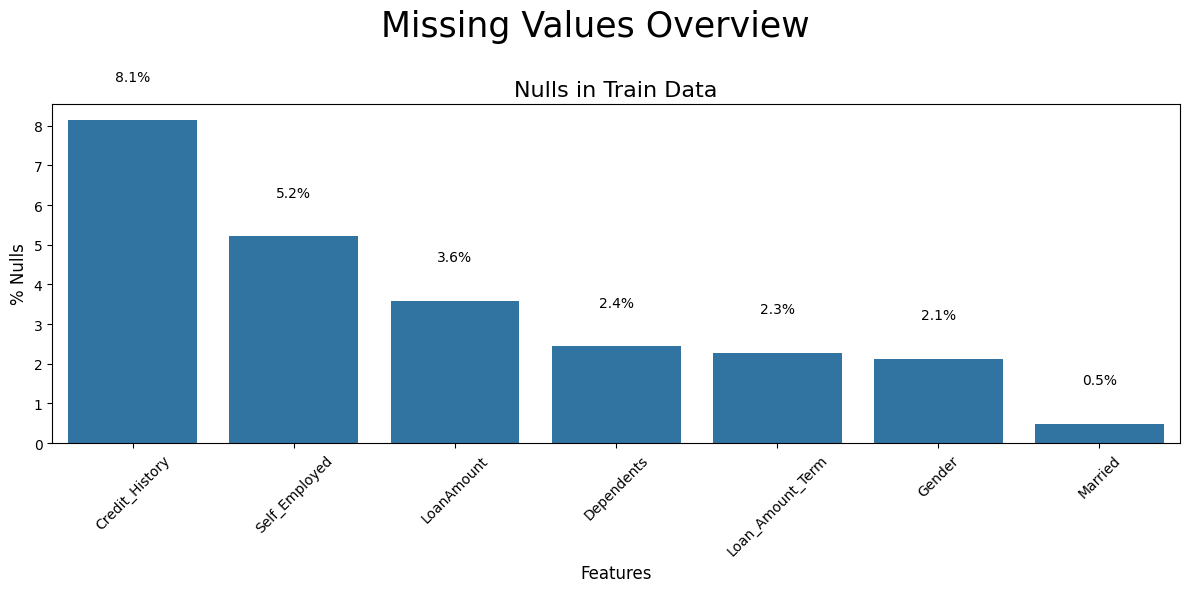

In [14]:
def plot_nulls_short(train):
    fig, ax = plt.subplots(figsize=(12, 6))  # removed list/loop since only one axis

    null_percent = train.isnull().mean() * 100
    null_percent = null_percent[null_percent > 0].sort_values(ascending=False)
    sns.barplot(x=null_percent.index, y=null_percent.values, ax=ax)
    ax.set_title('Nulls in Train Data', fontsize=16)
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('% Nulls', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    for i, val in enumerate(null_percent.values):
        ax.text(i, val + 1, f'{val:.1f}%', ha='center')

    plt.suptitle('Missing Values Overview', fontsize=25)
    plt.tight_layout()
    plt.show()

# Run it
plot_nulls_short(df)


Checking duplicate of the dataset

In [23]:
print(f"There are {df.duplicated().sum()} duplicate in this dataset")

There are 0 duplicate in this dataset


Checking imbalance dataset

In [40]:
train_target = df["Loan_Status"].value_counts()
print("The Target distribution:")
for label, train in train_target.items():
    print(f"{label}: {train}")

The Target distribution:
Y: 422
N: 192


In [38]:
train_target_percent = df["Loan_Status"].value_counts(normalize=True) *100
print("The Target distribution:")
for label, train in train_target_percent.items():
    print(f"{label}: {train: 2f}%")

The Target distribution:
Y:  68.729642%
N:  31.270358%


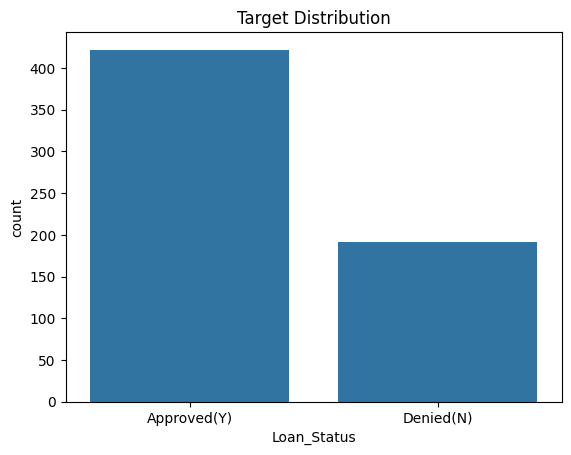

In [41]:
sns.countplot(x="Loan_Status" , data=df)
plt.title("Target Distribution")
plt.xticks(["Y","N"], ["Approved(Y)","Denied(N)"])
plt.show()

From this analysis we can say this dataset is not imbalance 

Checking Statisitical Information

In [43]:
df.describe().T.sort_values(by="std", ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


Checking datatype of each columns

In [48]:
print(f"The Datatype of each columns is sated below: \n{df.dtypes}")

The Datatype of each columns is sated below: 
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


Splitting into numerical and categorical

In [52]:
numerical_columns = [feature for feature in df.columns if df[feature].dtypes != "O"  and feature not in["Loan_ID"]]
print(f"Number of numeric variable: {len(numerical_columns)}")

df[numerical_columns].head()

Number of numeric variable: 5


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


Spliting numerical into discrete and continuous numerical coulumns

#### Numetrical Columns

In [56]:
discrete_numerical_columns = [feature for feature in numerical_columns if len(df[feature].unique()) < 25]
print(f"Number of discrete varaible: {len(discrete_numerical_columns)}")

df[discrete_numerical_columns].head()

Number of discrete varaible: 2


,Loan_Amount_Term,Credit_History
0,360.0,1.0
1,360.0,1.0
2,360.0,1.0
3,360.0,1.0
4,360.0,1.0


In [87]:
continuous_numerical_columns = [feature for feature in numerical_columns if feature not in discrete_numerical_columns]
print(f"Number of continuous variable: {len(continuous_numerical_columns)}")

df[continuous_numerical_columns].head()

Number of continuous variable: 3


,ApplicantIncome,CoapplicantIncome,LoanAmount
0,5849,0.0,NaN
1,4583,1508.0,128.0
2,3000,0.0,66.0
3,2583,2358.0,120.0
4,6000,0.0,141.0


In [63]:
for feature in discrete_numerical_columns:
    print(f"Unique value in {feature}")
    print(df[feature].unique())
    print("-"*30)

Unique value in Loan_Amount_Term
[360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]
------------------------------
Unique value in Credit_History
[ 1.  0. nan]
------------------------------


In [64]:
for feature in continuous_numerical_columns:
    print(f"Unique value in {feature}")
    print(df[feature].unique())
    print("-"*30)

Unique value in ApplicantIncome
[ 5849  4583  3000  2583  6000  5417  2333  3036  4006 12841  3200  2500
  3073  1853  1299  4950  3596  3510  4887  2600  7660  5955  3365  3717
  9560  2799  4226  1442  3750  4166  3167  4692  3500 12500  2275  1828
  3667  3748  3600  1800  2400  3941  4695  3410  5649  5821  2645  4000
  1928  3086  4230  4616 11500  2708  2132  3366  8080  3357  3029  2609
  4945  5726 10750  7100  4300  3208  1875  4755  5266  1000  3333  3846
  2395  1378  3988  2366  8566  5695  2958  6250  3273  4133  3620  6782
  2484  1977  4188  1759  4288  4843 13650  4652  3816  3052 11417  7333
  3800  2071  5316  2929  3572  7451  5050 14583  2214  5568 10408  5667
  2137  2957  3692 23803  3865 10513  6080 20166  2014  2718  3459  4895
  3316 14999  4200  5042  6950  2698 11757  2330 14866  1538 10000  4860
  6277  2577  9166  2281  3254 39999  9538  2980  1863  7933  3089  4167
  9323  3707  2439  2237  8000  1820 51763  3522  5708  4344  3497  2045
  5516  6400  1916 

#### Categorical columns

In [70]:
categorical_columns = [feature for feature in df.columns if df[feature].dtypes == "O" and feature not in ["Loan_ID"]]
print(f"Number of categoriical columns: {len(categorical_columns)}")

df[categorical_columns].head()

Number of categoriical columns: 7


,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y


In [72]:
for feature in categorical_columns:
    print(f"Unique Value in {feature}")
    print(df[feature].unique())
    print("="*30)

Unique Value in Gender
['Male' 'Female' nan]
Unique Value in Married
['No' 'Yes' nan]
Unique Value in Dependents
['0' '1' '2' '3+' nan]
Unique Value in Education
['Graduate' 'Not Graduate']
Unique Value in Self_Employed
['No' 'Yes' nan]
Unique Value in Property_Area
['Urban' 'Rural' 'Semiurban']
Unique Value in Loan_Status
['Y' 'N']


### EDA analysis

#### Univerate Analysis for numerical columns

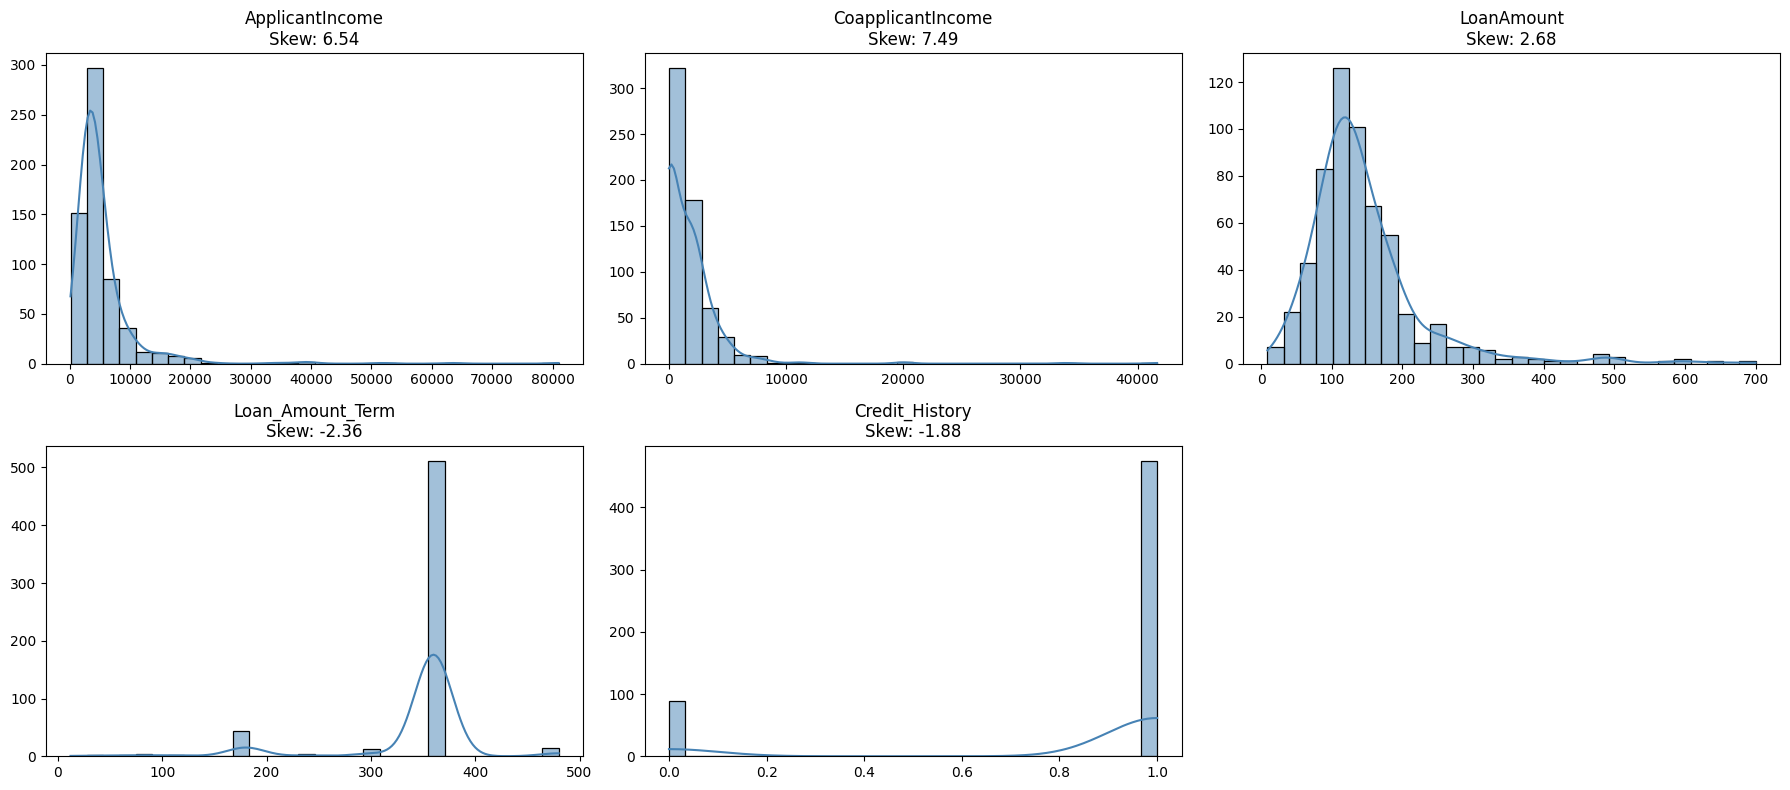

In [82]:

import math

# Assuming `continuous_numerical_columns` is your list of continuous features
n_cols = 3  # You can change this to 3 or 4 if you want more per row
n_rows = math.ceil(len(numerical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()  # Flatten in case of 1D

for i, feature in enumerate(numerical_columns):
    sns.histplot(df[feature], kde=True, bins=30, ax=axes[i], color='steelblue')
    axes[i].set_title(f"{feature}\nSkew: {df[feature].skew():.2f}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Application, coappliction and LoanAmount are right skewed which would be handle in feature engineering

In [146]:
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")

ApplicantIncome: 50 outliers
CoapplicantIncome: 18 outliers
LoanAmount: 39 outliers
Loan_Amount_Term: 88 outliers
Credit_History: 89 outliers


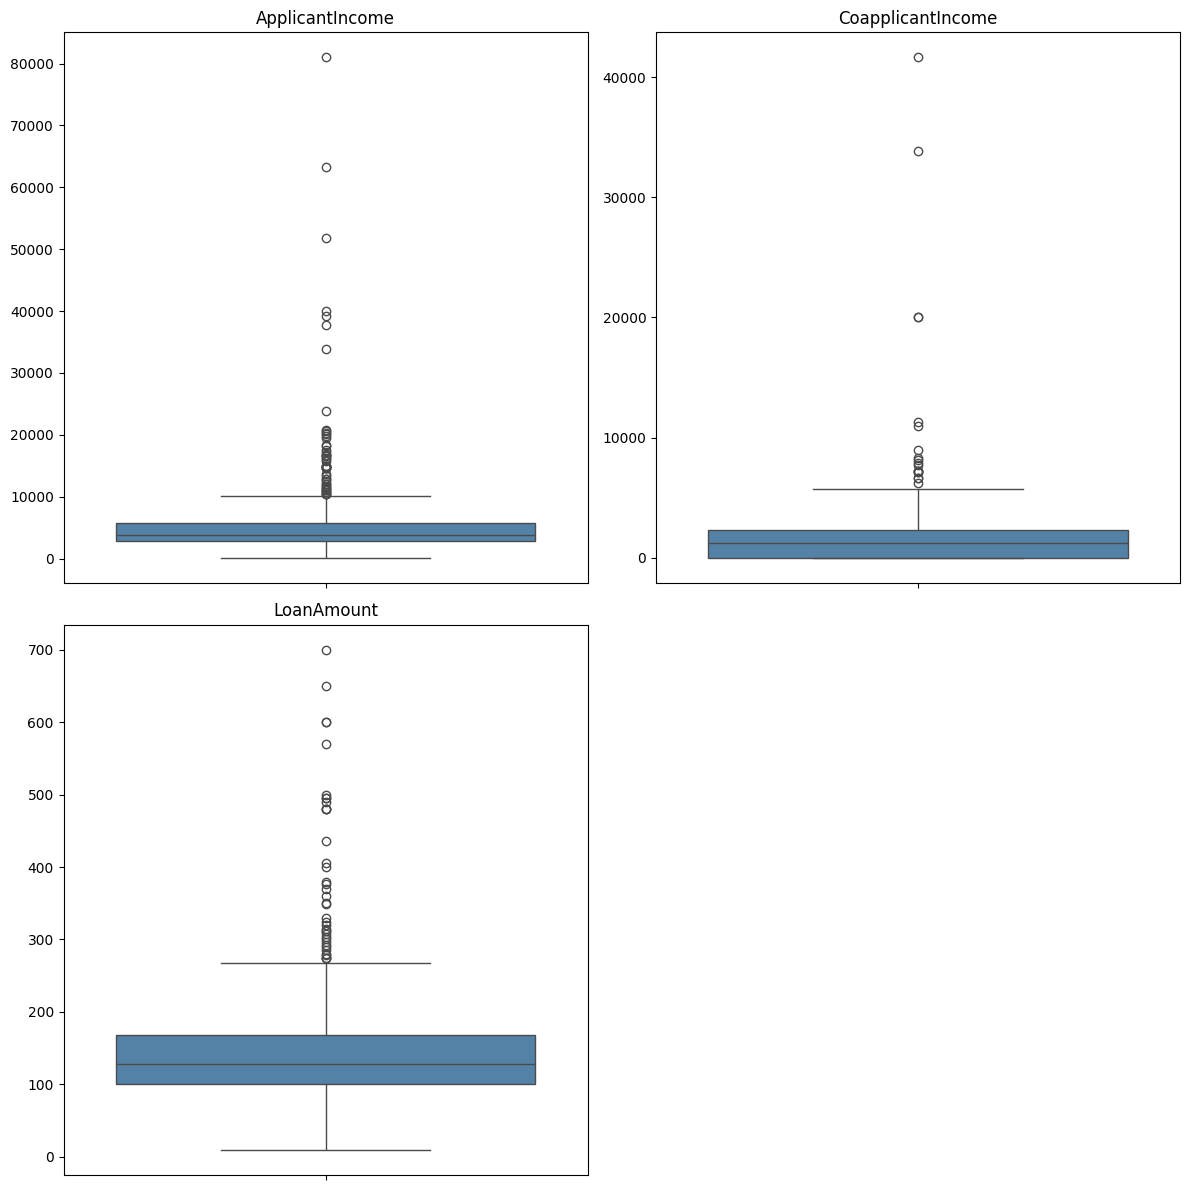

In [90]:
##Using box-plot
n_cols = 2
n_rows = math.ceil(len(continuous_numerical_columns)/n_cols)

fig, axes = plt.subplots(n_cols,n_rows, figsize=(n_cols*6, n_rows*6))
axes = axes.flatten()

for i, feature in enumerate(continuous_numerical_columns):
    sns.boxplot(df[feature],ax=axes[i],color="steelblue")
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Application, coappliction and LoanAmount have outlier which would be handle in feature enginnering

#### Univerate Analysis for categorical columns

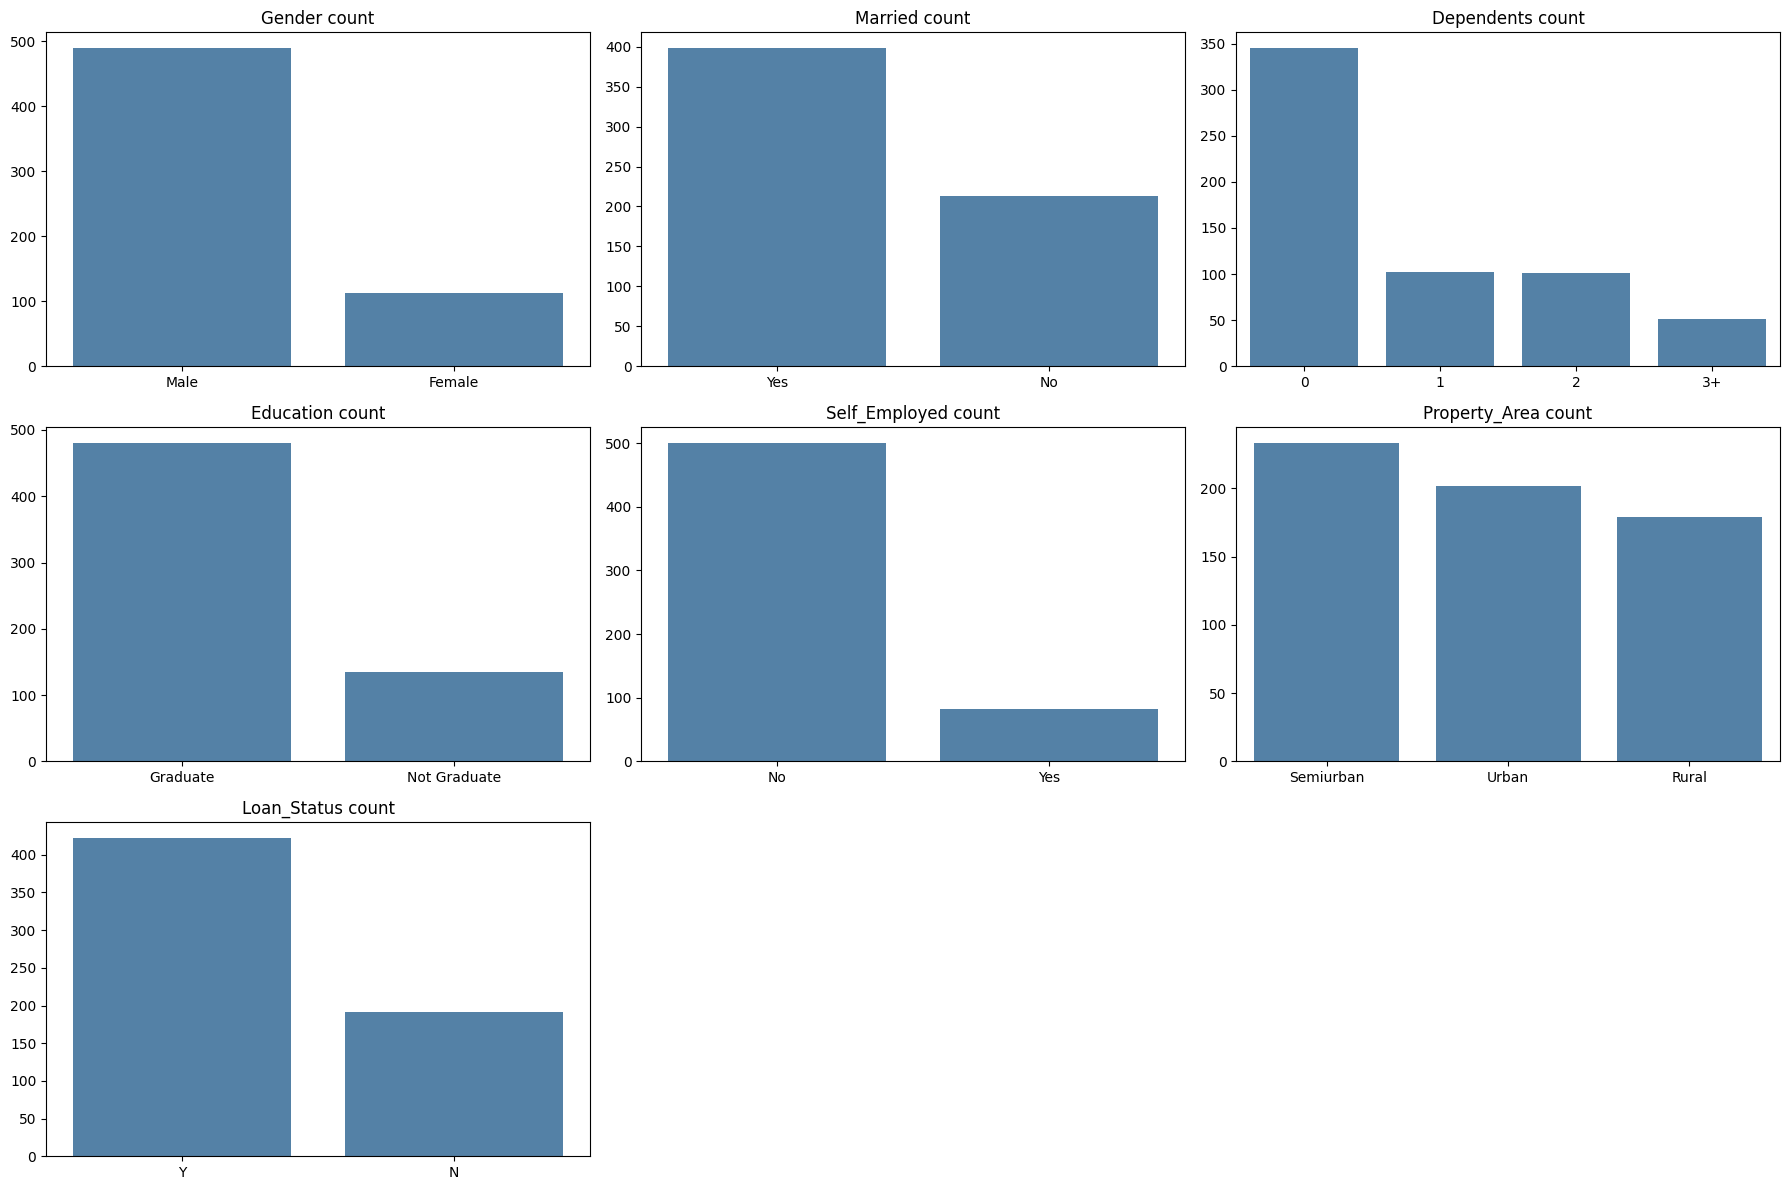

In [97]:
n_cols = 3
n_rows = math.ceil(len(categorical_columns)/n_cols)

fig, axes = plt.subplots(n_cols, n_rows, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()

for i, feature in enumerate(categorical_columns):
    sns.countplot(data=df,x = feature, order=df[feature].value_counts().index,ax=axes[i], color="steelblue")
    axes[i].set_title(f"{feature} count")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Bivariant analysis for numerical columns

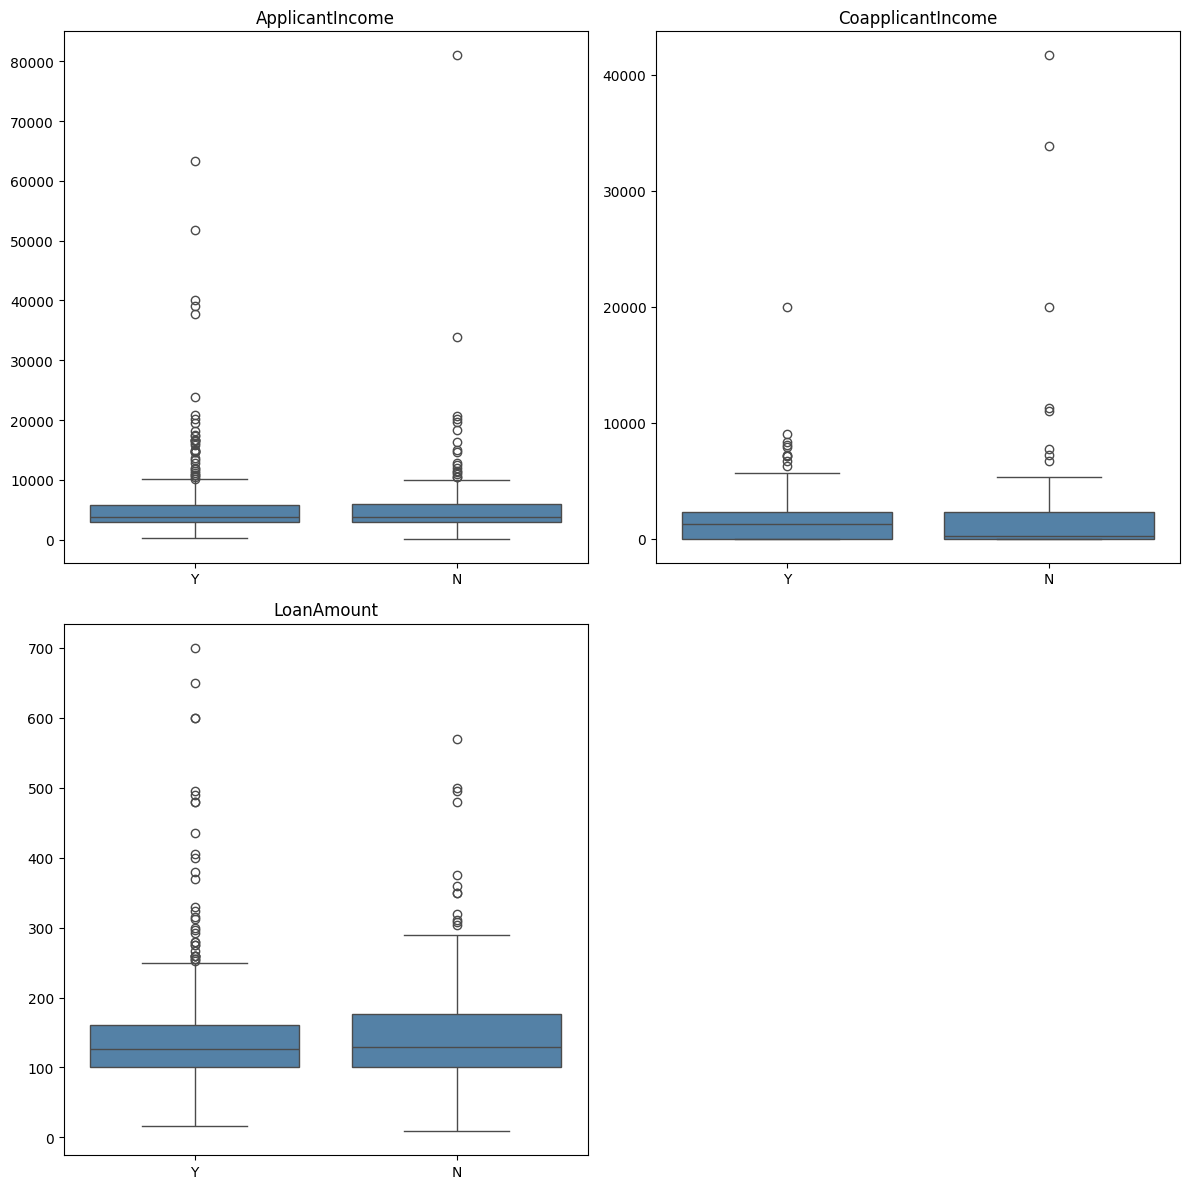

In [113]:
##Using box-plot
n_cols = 2
n_rows = math.ceil(len(continuous_numerical_columns)/n_cols)

fig, axes = plt.subplots(n_cols,n_rows, figsize=(n_cols*6, n_rows*6))
axes = axes.flatten()

for i, feature in enumerate(continuous_numerical_columns):
    sns.boxplot(data=df, x= 'Loan_Status', y=feature,ax=axes[i],color="steelblue")
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


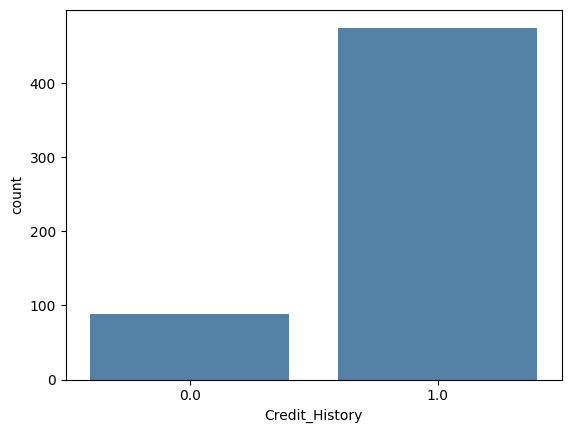

In [112]:
sns.countplot(data=df,x ="Credit_History", color="steelblue")
plt.show()

| Feature             | Median Difference (`Y` vs `N`) | Skew/Outliers            | Insight                                  | Action / Next Step                |
| ------------------- | ------------------------------ | ------------------------ | ---------------------------------------- | --------------------------------- |
| `ApplicantIncome`   |  Very similar                |  High skew              | Applicant income alone has weak effect   | Use with `Total_Income` or ratios |
| `CoapplicantIncome` |  Higher for `Y`               | Outliers exist         | Coapplicant helps slightly               | Combine to `Total_Income`         |
| `LoanAmount`        |  Higher for `N`               | Skewed & outliers      | Higher loans less likely to get approved | Apply log + create ratio features |
| `Loan_Amount_Term`  |  No clear pattern             |  Mostly same            | Not useful as-is                         | Bin or drop if not informative    |
| `Credit_History`    | Strongly favors `Y`          | ⏸ Binary                 | Most important single predictor          | Keep as-is                        |
| `Total_Income`      |  Better separation            | Right-skewed           | Captures both incomes well               | Use in model, normalize if needed |
| `Income_Loan_Ratio` | Stronger pattern             |  Depends on LoanAmount | Shows income affordability               | Very useful feature               |


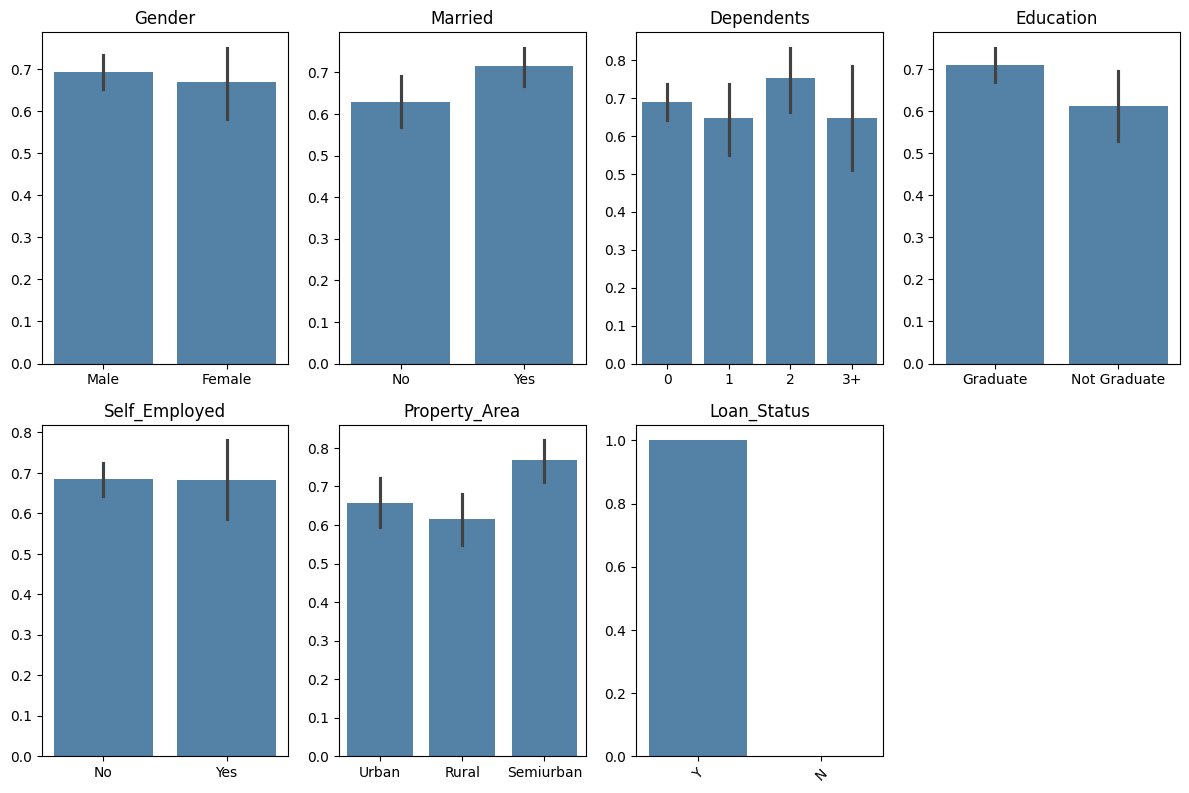

In [120]:
n_cols = 2
n_rows = math.ceil(len(categorical_columns)/n_cols)

fig, axes = plt.subplots(n_cols,n_rows, figsize=(n_cols*6, n_rows*2))
axes = axes.flatten()

df["Loan_Status_num"] = df["Loan_Status"].map({"Y":1,"N":0})
for i, feature in enumerate(categorical_columns):
    sns.barplot(data=df,x=feature,y="Loan_Status_num" ,ax=axes[i],color="steelblue")
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
   

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


| Feature            | What to Look For                               | Insight Example                                                                           |
| ------------------ | ---------------------------------------------- | ----------------------------------------------------------------------------------------- |
| **Gender**         | Are males or females more likely to get loans? | If both genders have similar approval rates, gender isn’t a strong factor.                |
| **Married**        | Does being married help in getting a loan?     | If married applicants have higher approval rate → may be considered more stable.          |
| **Dependents**     | Do dependents affect approval?                 | If 3+ dependents have lower approval → more financial burden may impact approval.         |
| **Education**      | Do graduates get loans more often?             | If graduates have higher approval → education may be considered in creditworthiness.      |
| **Self\_Employed** | Are self-employed treated differently?         | If self-employed has lower rate → banks may see them as riskier.                          |
| **Property\_Area** | Urban vs Rural vs Semiurban                    | If semiurban has highest approval → policies or employment stability may affect decision. |


| Type                      | Examples                                                     |
| ------------------------- | ------------------------------------------------------------ |
| Categorical vs Target  | `groupby("Gender")["Loan_Status"].value_counts()`            |
| Numeric vs Target      | `groupby("Loan_Status")["ApplicantIncome"].median()`         |
| Categorical vs Numeric | `groupby(["Education", "Loan_Status"])["LoanAmount"].mean()` |


In [135]:
target_col = "Loan_Status"

# # Safe map only if it's not already numeric
# if df[target_col].dtype == 'object':
#     df[target_col] = df[target_col].map({'Y': 1, 'N': 0})

for col in categorical_columns:
    print(f"\n{col} vs {target_col} (Normalized Counts):")
    print(df.groupby(col)[target_col].value_counts(normalize=True))

    print(f"\n{col} vs Avg Loan Approval Rate:")
    print(df.groupby(col)[target_col].mean())


for num_col in continuous_numerical_columns:
    print(f"\nAvg {num_col} by {col}:")
    print(df.groupby(col)[num_col].mean())


Gender vs Loan_Status (Normalized Counts):
Gender  Loan_Status
Female  1              0.669643
        0              0.330357
Male    1              0.693252
        0              0.306748
Name: proportion, dtype: float64

Gender vs Avg Loan Approval Rate:
Gender
Female    0.669643
Male      0.693252
Name: Loan_Status, dtype: float64

Married vs Loan_Status (Normalized Counts):
Married  Loan_Status
No       1              0.629108
         0              0.370892
Yes      1              0.716080
         0              0.283920
Name: proportion, dtype: float64

Married vs Avg Loan Approval Rate:
Married
No     0.629108
Yes    0.716080
Name: Loan_Status, dtype: float64

Dependents vs Loan_Status (Normalized Counts):
Dependents  Loan_Status
0           1              0.689855
            0              0.310145
1           1              0.647059
            0              0.352941
2           1              0.752475
            0              0.247525
3+          1              0.647


Visualizing numeric features grouped by: Gender


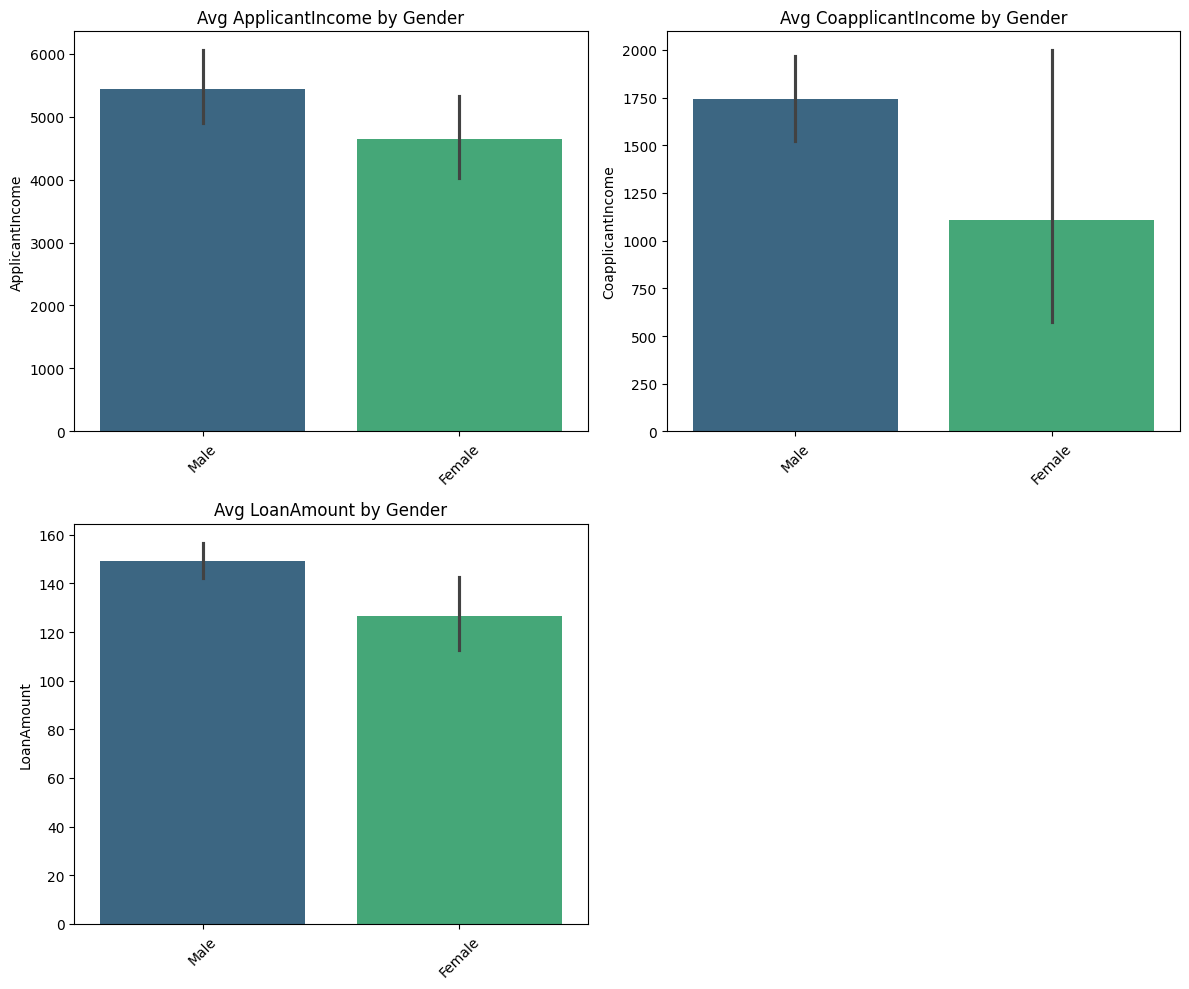


Visualizing numeric features grouped by: Married


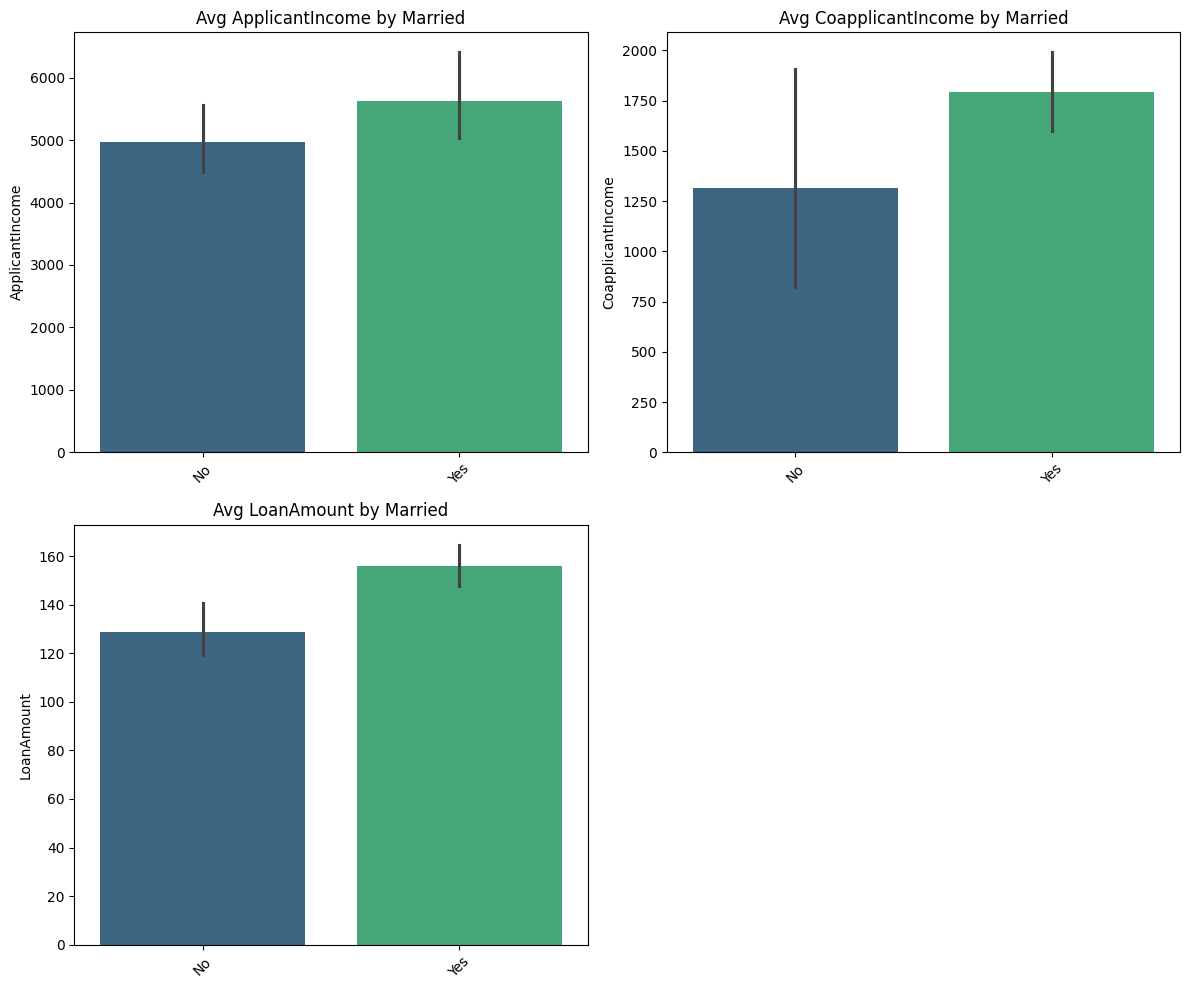


Visualizing numeric features grouped by: Dependents


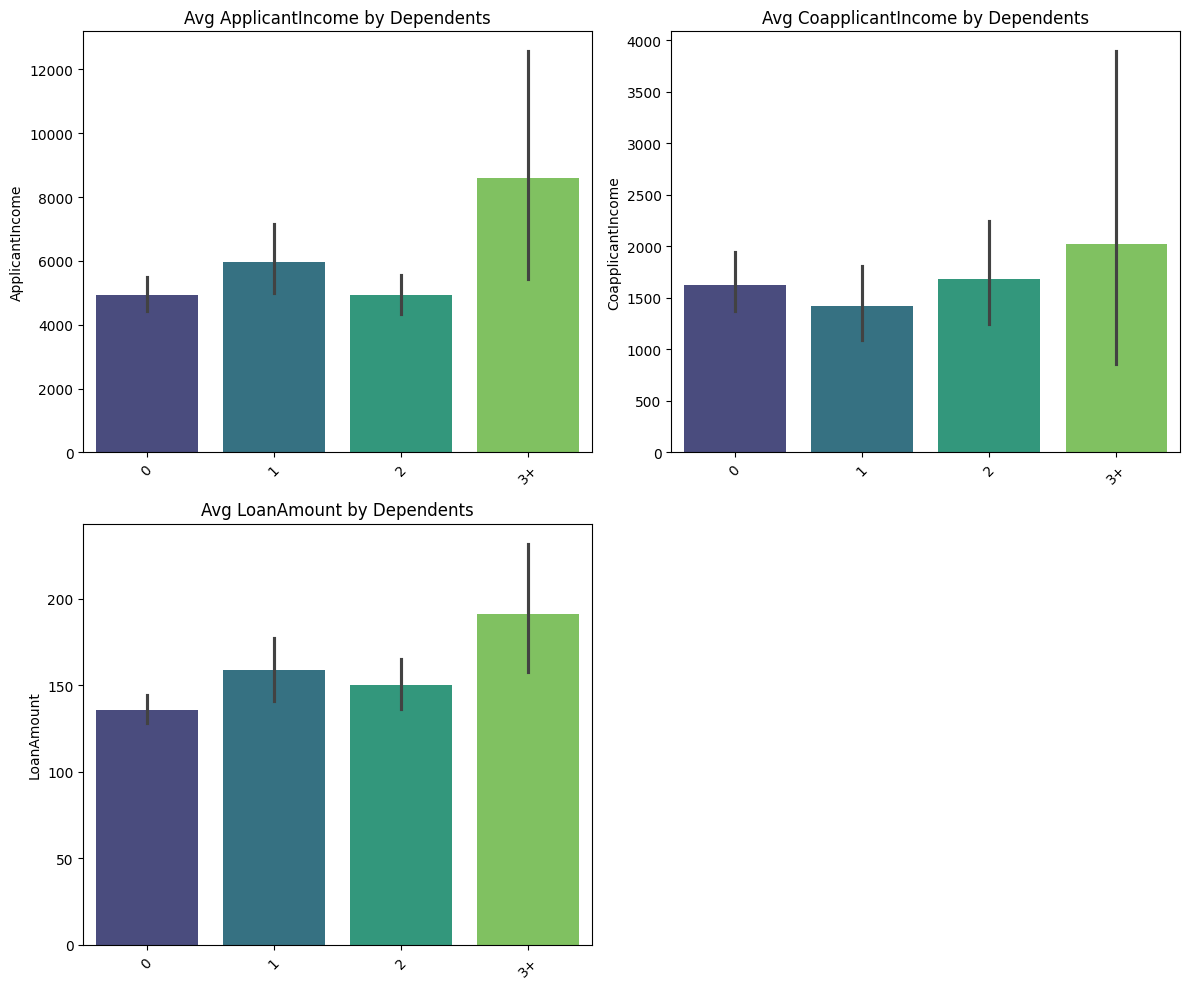


Visualizing numeric features grouped by: Education


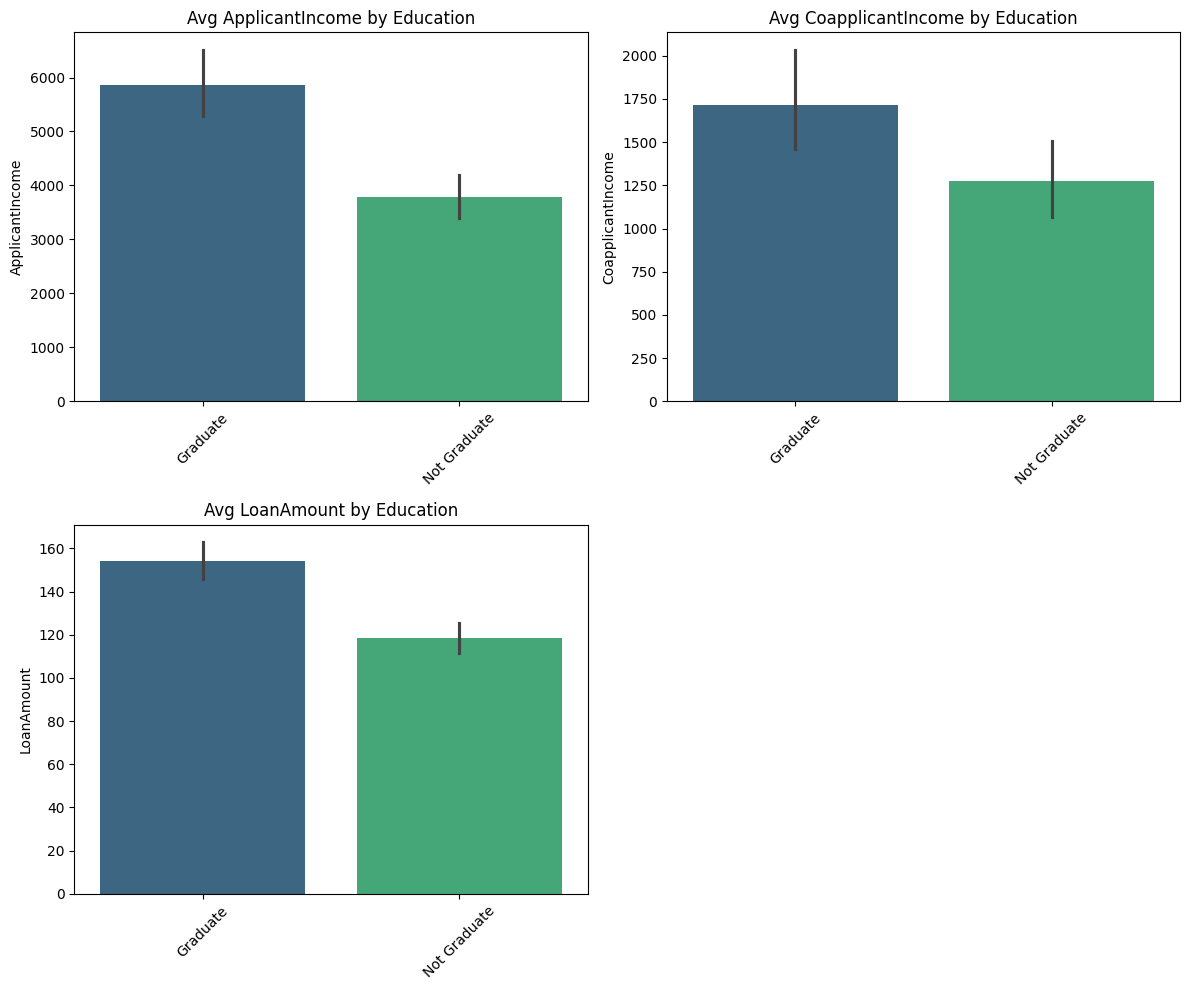


Visualizing numeric features grouped by: Self_Employed


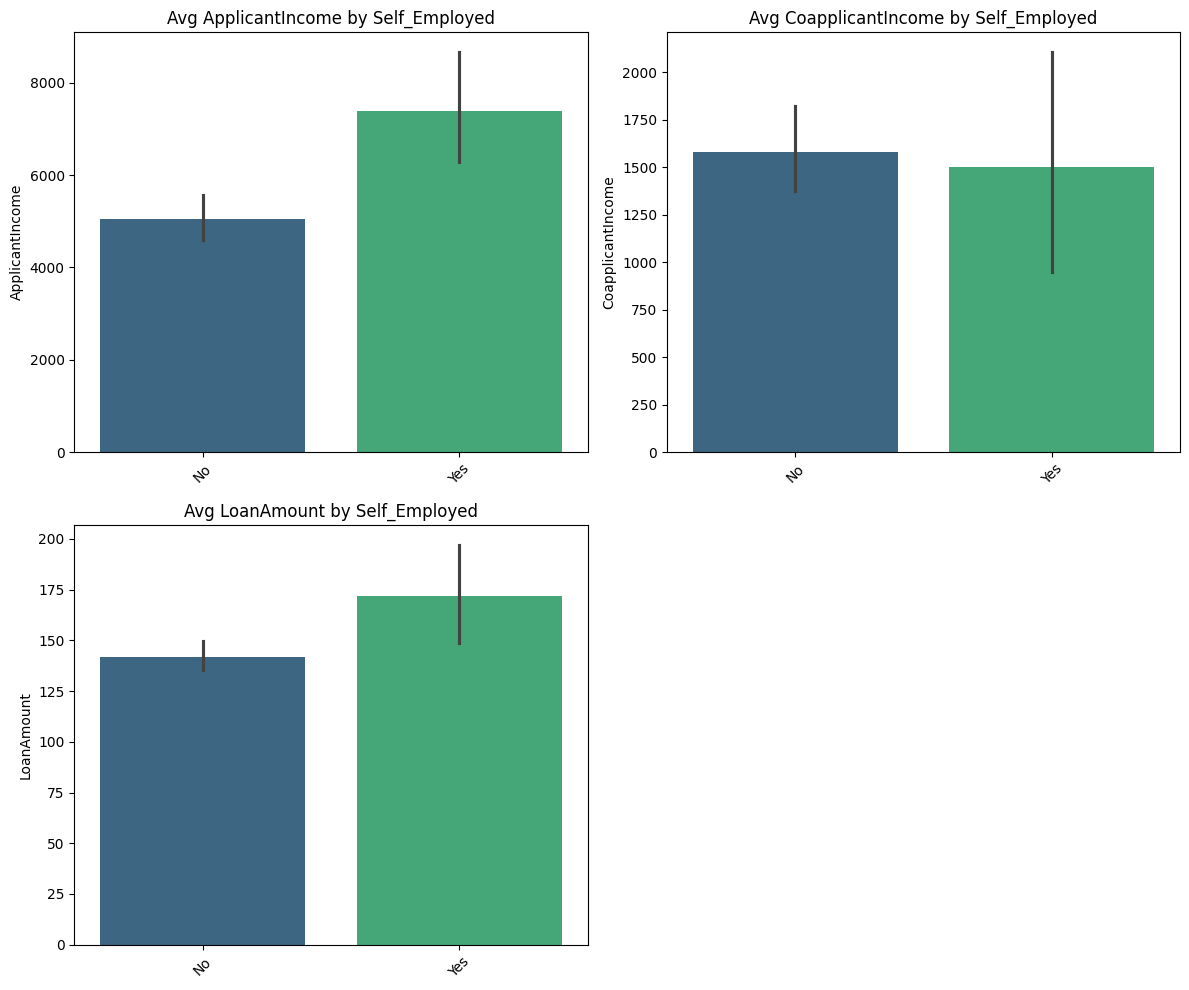


Visualizing numeric features grouped by: Property_Area


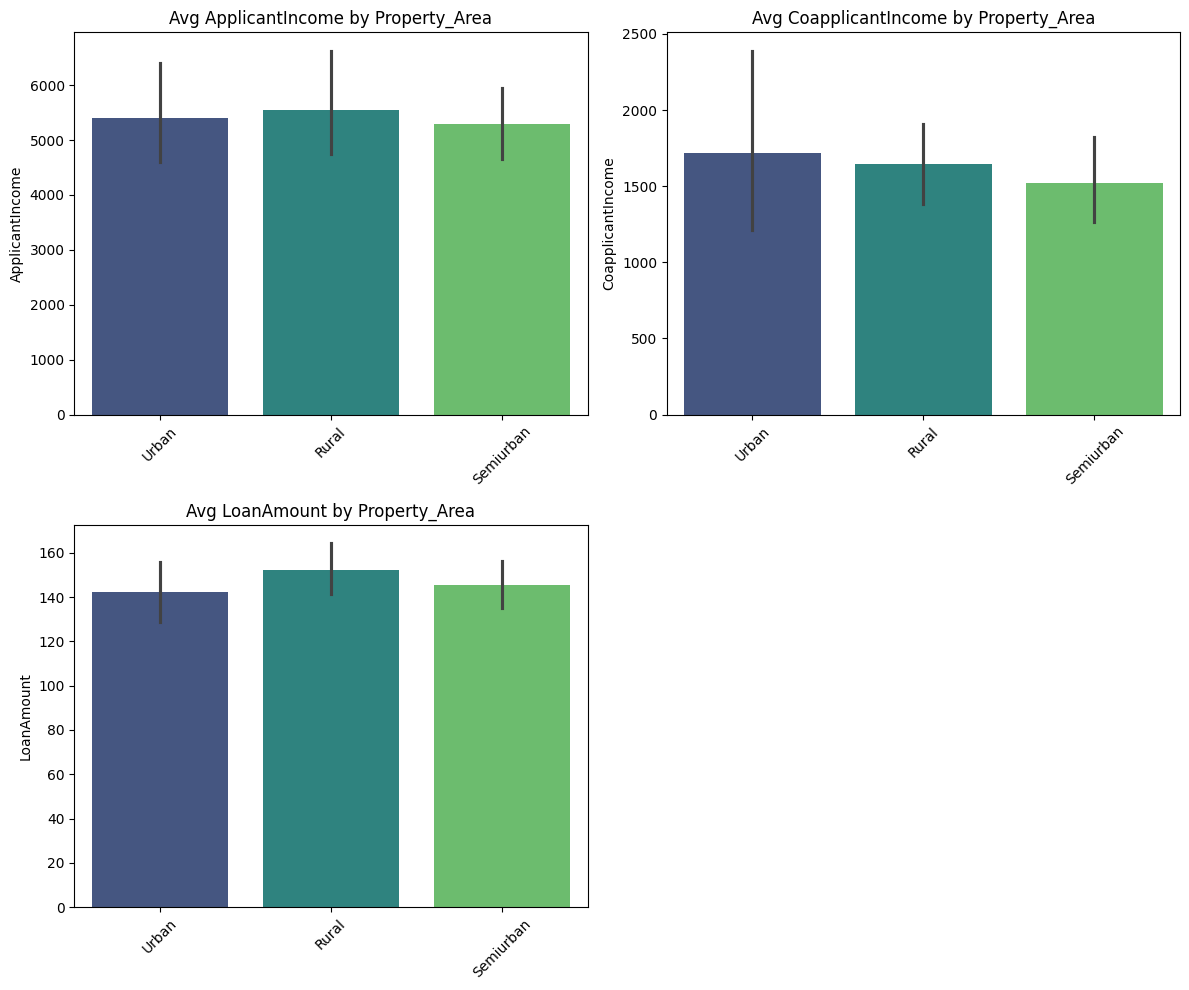


Visualizing numeric features grouped by: Loan_Status


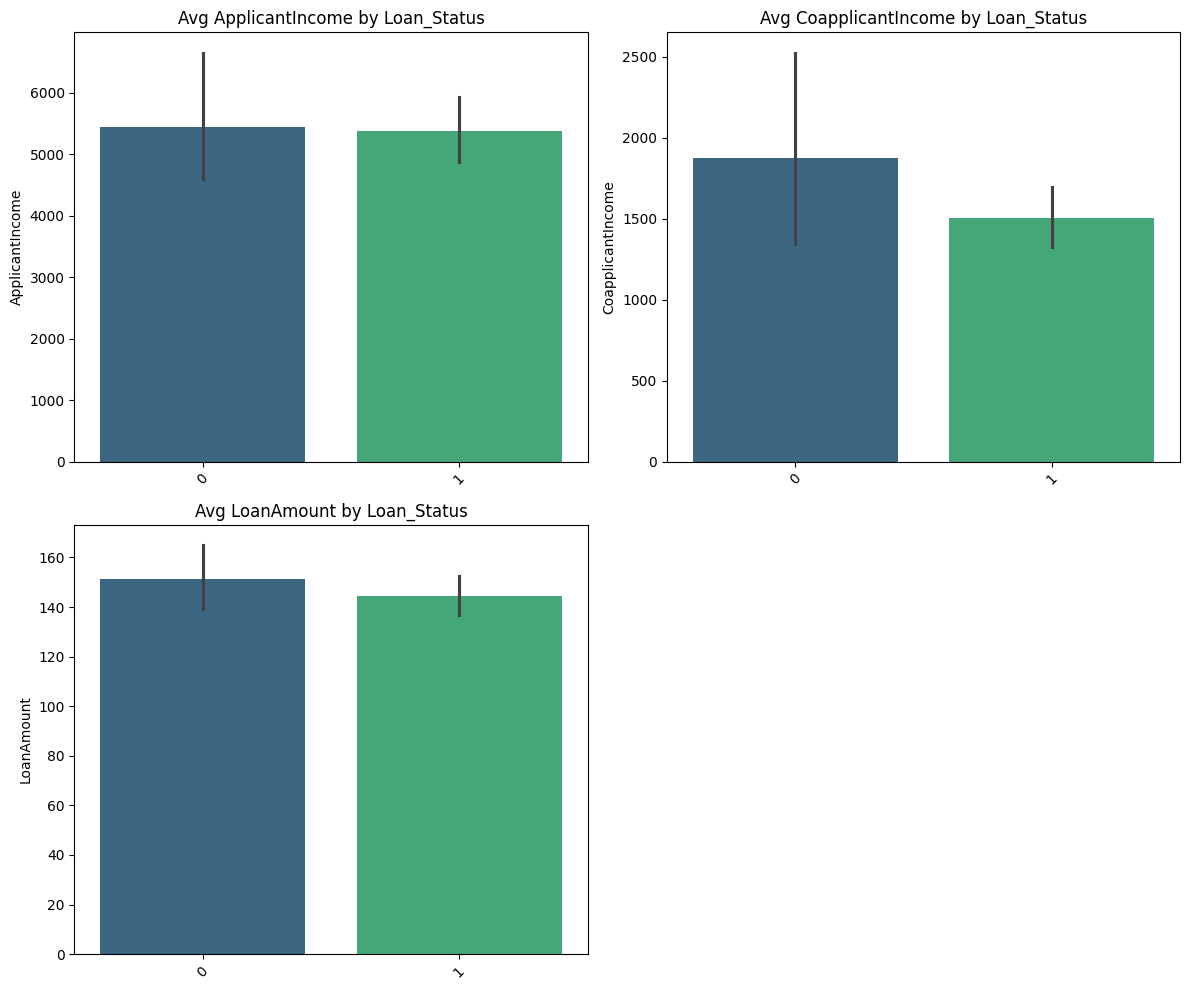

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Loop over each categorical column
for cat_col in categorical_columns:
    print(f"\nVisualizing numeric features grouped by: {cat_col}")

    n_cols = 2
    n_rows = math.ceil(len(continuous_numerical_columns) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
    axes = axes.flatten()

    for i, num_col in enumerate(continuous_numerical_columns):
        sns.barplot(data=df, x=cat_col, y=num_col, ax=axes[i], palette='viridis')
        axes[i].set_title(f"Avg {num_col} by {cat_col}")
        axes[i].set_ylabel(num_col)
        axes[i].set_xlabel("")
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
